In [19]:
import pandas as pd
import numpy as np
import os
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss
import joblib

In [20]:
# Function to load CSV files from a directory and assign labels
def load_csvs_from_folder(folder_path, label):
    csv_files = glob(os.path.join(folder_path, '*.csv'))
    dataframes = []
    for file in csv_files:
        df = pd.read_csv(file)
        df['Class'] = label  # Assign class label (0 for animal, 1 for plant)
        dataframes.append(df)
    return pd.concat(dataframes, ignore_index=True)

In [21]:
# Load data from two directories
animal_oils_folder = 'readings/Animal'
plant_oils_folder = 'readings/Plant'

In [22]:
# Load data for both classes
animal_oils_data = load_csvs_from_folder(animal_oils_folder, label=0)
plant_oils_data = load_csvs_from_folder(plant_oils_folder, label=1)

In [23]:
# Combine both datasets into a single DataFrame
df = pd.concat([animal_oils_data, plant_oils_data], ignore_index=True)

In [24]:
# Check the structure of the combined data
print(df.head())
print(df['Class'].value_counts())

   MQ2  MQ3  MQ4  MQ5  MQ6  MQ7  MQ8  MQ9  MQ135  MQ137  Class
0  38  152   53   27   97  196  333  175    100    171      0
1   37  153   54   27   97  197  334  176     99    172      0
2   37  153   54   26   98  195  333  175     99    171      0
3   38  155   54   28   97  198  333  176     99    171      0
4   37  154   54   27   98  196  335  177     99    172      0
Class
1    49888
0    49335
Name: count, dtype: int64


In [25]:
# Split features (X) and target (y)
X = df.drop(columns='Class')
y = df['Class']

In [26]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=32)

In [27]:
# Define the pipeline with PCA and XGBClassifier
pipeline = Pipeline([
    ('pca', PCA()),  # Principal Component Analysis
    ('clf', XGBClassifier(random_state=32, eval_metric='logloss'))  # XGBoost Classifier
])

In [28]:
# Define the search space for Bayesian optimization
search_space = {
    'clf__max_depth': Integer(2, 8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode': Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0),
    'pca__n_components': Integer(2, min(X_train.shape[1], 9))
}

# Use BayesSearchCV for hyperparameter optimization
opt = BayesSearchCV(pipeline, search_space, cv=5, n_iter=12, scoring='roc_auc_ovr', random_state=32)
opt.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('pca', PCA()),
                                        ('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric='logloss',
                                                       feature_types=None,
                                                       gamma=None,
                                                       grow_policy=None,
                                                       importance_type=None,
                                                       inter...
                             'clf__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize'),
                             'pca__n_components': Integer(low=2, high=9, prior='uniform', transform='normalize')})

In [30]:
# Best model and its performance
print("Best Estimator:", opt.best_estimator_)
print("Best Score on Training Data:", opt.best_score_)
print("Score on Test Data:", opt.score(X_test, y_test))

Best Estimator: Pipeline(steps=[('pca', PCA(n_components=6)),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=0.6146223377116606,
                               colsample_bynode=0.5260577047646148,
                               colsample_bytree=0.5800012933546727, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=0.13552975266814182,
                               g...one, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.1852903338347364, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=6,
                               max_leaves=None, min_chi

ValueError: could not convert string to float: '\x1838'

In [31]:
# Predictions and probabilities
y_pred = opt.predict(X_test)
y_proba = opt.predict_proba(X_test)

ValueError: could not convert string to float: '\x1838'

In [13]:
# Evaluate accuracy and log loss
accuracy = accuracy_score(y_test, y_pred)
logloss = log_loss(y_test, y_proba)
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {logloss}")

Test Accuracy: 0.9993636652879414
Test Log Loss: 0.006013087331753605


In [32]:
# Save the best estimator
model_save_path = 'models/dec8_xgboost_oil_classifier_model.joblib'
joblib.dump(opt.best_estimator_, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to models/dec8_xgboost_oil_classifier_model.joblib


In [33]:
# Save the PCA transformer separately
pca_save_path = 'models/new_pca_transformer.joblib'
best_pca = opt.best_estimator_.named_steps['pca']
joblib.dump(best_pca, pca_save_path)
print(f"PCA transformer saved to {pca_save_path}")

PCA transformer saved to models/new_pca_transformer.joblib


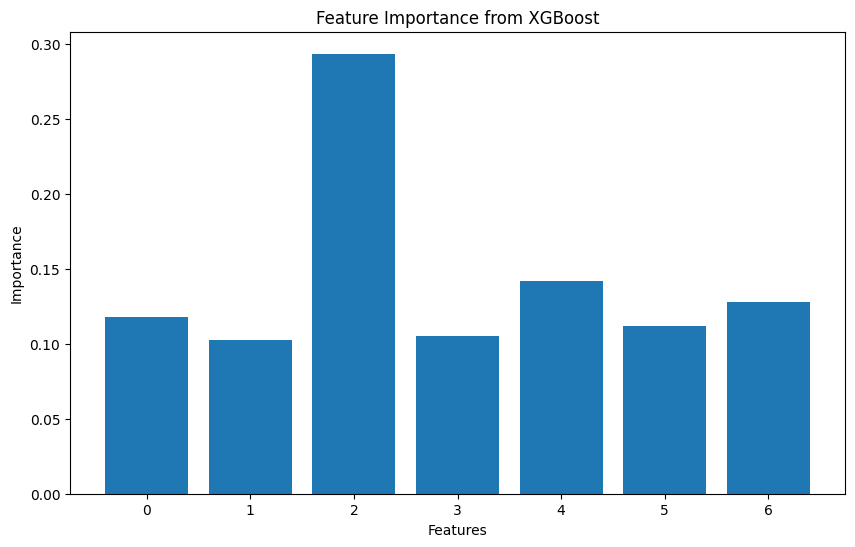

In [16]:
# Feature importance from XGBoost
feature_importance = opt.best_estimator_.named_steps['clf'].feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.title('Feature Importance from XGBoost')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [17]:
# PCA Visualization
pca = opt.best_estimator_.named_steps['pca']
#X_train_pca = pca.transform(X_train)
#X_test_pca = pca.transform(X_test)
X_train_pca = best_pca.transform(X_train)
X_test_pca = best_pca.transform(X_test)


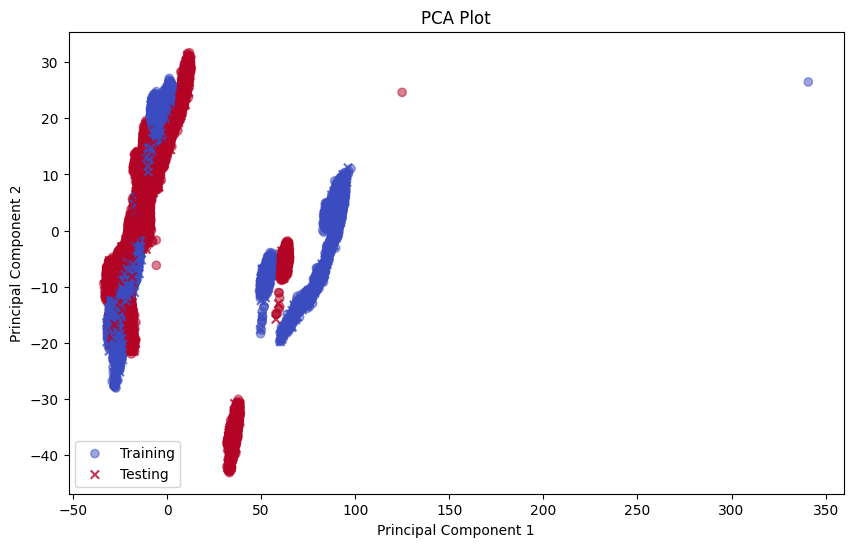

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='coolwarm', alpha=0.5, label='Training')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='coolwarm', marker='x', alpha=0.8, label='Testing')
plt.title('PCA Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()